In [1]:

from dotenv import load_dotenv
load_dotenv()
import os
os.environ['GROQ_API_KEY'] = os.getenv("GROQ_API_KEY")

In [2]:
model="deepseek-r1-distill-llama-70b"

### Load the Model

In [3]:
model="deepseek-r1-distill-llama-70b"
from langchain_groq import ChatGroq
llm=ChatGroq(model_name=model)
llm.invoke("hi")

AIMessage(content='<think>\n\n</think>\n\nHello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 4, 'total_tokens': 18, 'completion_time': 0.070609756, 'prompt_time': 5.5479e-05, 'queue_time': 0.205900835, 'total_time': 0.070665235}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'stop', 'logprobs': None}, id='run--5462bcf7-78ca-4671-8f46-eeef2d9dd021-0', usage_metadata={'input_tokens': 4, 'output_tokens': 14, 'total_tokens': 18})

In [4]:
print(llm.invoke("hi").content)

<think>

</think>

Hello! How can I assist you today? 😊


In [5]:
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,MessagesState,START,END
from langgraph.prebuilt import ToolNode

In [39]:
def call_model(state: MessagesState):
    message = state["messages"]
    response = llm.invoke(message)

    return {"messages": [response]}

In [40]:
state = {"messages": ["Hi, How are you?"]}

call_model(state)

{'messages': [AIMessage(content="<think>\n\n</think>\n\nHi! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you with whatever you need. How are you doing? 😊", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 9, 'total_tokens': 51, 'completion_time': 0.216766614, 'prompt_time': 0.000194649, 'queue_time': 0.20608226200000002, 'total_time': 0.216961263}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'stop', 'logprobs': None}, id='run--81828a20-af0d-4c81-9601-0f4b6318913e-0', usage_metadata={'input_tokens': 9, 'output_tokens': 42, 'total_tokens': 51})]}

### Design a simple workflow without tool calling

In [43]:
# def call_model(state: MessagesState):
#     question = state["messages"][-1]
#     message = HumanMessage([question])

#     print("This is my Human Message going to LLM ", message)

#     response = llm.invoke(message)

#     return {"messages": [response]}

In [44]:
workflow = StateGraph(MessagesState)

In [45]:
workflow.add_node("mybot", call_model)

In [46]:
workflow.add_edge(START, "mybot")

In [47]:
workflow.add_edge("mybot", END)

In [48]:
app = workflow.compile()

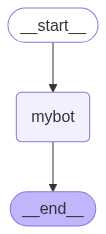

In [49]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [50]:
input={"messages":["hi hello how are you?"]}


In [51]:
app.invoke(input)

{'messages': [HumanMessage(content='hi hello how are you?', additional_kwargs={}, response_metadata={}, id='6e8fc0ea-15e5-45df-8ffa-9970621b8e9f'),
  AIMessage(content="<think>\n\n</think>\n\nHello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you with whatever you need. How are you doing? 😊", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 9, 'total_tokens': 51, 'completion_time': 0.197445219, 'prompt_time': 0.000189209, 'queue_time': 0.206126909, 'total_time': 0.197634428}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'stop', 'logprobs': None}, id='run--cdbe3956-71e3-42f5-a0db-0cab44fbcf30-0', usage_metadata={'input_tokens': 9, 'output_tokens': 42, 'total_tokens': 51})]}

#### Creating custom tool

In [52]:
@tool
def search(query:str):
    """this is my custom tool for searching a weather"""
    if "delhi" in query.lower():
        return "the temp is 45 degree celsius"
    return "the temp is 25 degree celsius"

In [53]:
search.invoke("what is temperature in Charlotte?")

'the temp is 25 degree celsius'

#### Binding the tool with flow

In [54]:
search

StructuredTool(name='search', description='this is my custom tool for searching a weather', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x0000012FEEF27880>)

In [55]:
tools = [search]

In [56]:
tools

[StructuredTool(name='search', description='this is my custom tool for searching a weather', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x0000012FEEF27880>)]

In [57]:
llm_with_tool = llm.bind_tools(tools)

In [59]:
response = llm_with_tool.invoke("what is weather in delhi?")

In [61]:
response.tool_calls

[{'name': 'search',
  'args': {'query': 'weather in Delhi'},
  'id': 'jg9fy5f57',
  'type': 'tool_call'}]

In [62]:
def call_model(state: MessagesState):
    question = state['messages']
    response = llm_with_tool.invoke(question)
    return {"messages": [response]}

In [63]:
input = {"messages": ["what is the weather in delhi?"]}

In [65]:
response = call_model(input)

In [66]:
response["messages"][-1].content

''

In [67]:
response["messages"][-1].tool_calls

[{'name': 'search',
  'args': {'query': 'weather in Delhi'},
  'id': '38pd5r9eg',
  'type': 'tool_call'}]

In [68]:
def router_function(state: MessagesState):
    message = state["messages"]
    last_message = message[-1]

    if last_message.tool_calls:
        return "tools"
    return END


In [69]:
tools

[StructuredTool(name='search', description='this is my custom tool for searching a weather', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x0000012FEEF27880>)]

In [79]:
workflow2 = StateGraph(MessagesState)

In [80]:
workflow2.add_node("llmwithtool",call_model)

In [81]:
tool_node = ToolNode(tools)

In [100]:
tool_node

tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'search': StructuredTool(name='search', description='this is my custom tool for searching a weather', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x0000012FEEF27880>)}, tool_to_state_args={'search': {}}, tool_to_store_arg={'search': None}, handle_tool_errors=True, messages_key='messages')

In [82]:
workflow2.add_node("mytools", tool_node)

In [83]:
workflow2.add_edge(START, "llmwithtool")

In [84]:
workflow2.add_conditional_edges("llmwithtool",
                                router_function,
                                {"tools": "mytools",
                                END: END})

In [85]:
app2 = workflow2.compile()

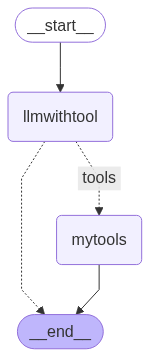

In [86]:
from IPython.display import Image, display
display(Image(app2.get_graph().draw_mermaid_png()))

In [87]:
response=app2.invoke({"messages":["what is a weather in bengraluru?"]})


In [88]:
response

{'messages': [HumanMessage(content='what is a weather in bengraluru?', additional_kwargs={}, response_metadata={}, id='37f3595e-37f9-4344-b56c-e40e1efef6ff'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, so the user is asking about the weather in Bengaluru. I need to figure out the best way to help them. They mentioned using a tool called "search" which is designed for weather searching. Let me recall the tool\'s parameters. It requires a "query" parameter, which is a string. \n\nI should format the query as "weather in Bengaluru" to get accurate results. Let me make sure the JSON structure is correct. The function name should be "search" and the arguments should have the query as "weather in Bengaluru". \n\nI think that\'s all. Let me put it together.\n', 'tool_calls': [{'id': 'vbc0sv7f6', 'function': {'arguments': '{"query":"weather in Bengaluru"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 152, 'prompt

In [89]:
response["messages"][-1].content


'the temp is 25 degree celsius'

In [90]:
app2.invoke({"messages":["what is a weather in delhi?"]})

{'messages': [HumanMessage(content='what is a weather in delhi?', additional_kwargs={}, response_metadata={}, id='d8d730a4-973d-4a2d-a744-65b8336d1d37'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking about the weather in Delhi. I need to use the provided tool to find this information. The tool is called "search" and it requires a query parameter. I\'ll structure the function call with the function name as "search" and the arguments as a JSON object containing the query. The query should be "weather in Delhi" to get the relevant results.\n', 'tool_calls': [{'id': 'pjf4z1dab', 'function': {'arguments': '{"query":"weather in Delhi"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 103, 'prompt_tokens': 133, 'total_tokens': 236, 'completion_time': 0.453165825, 'prompt_time': 0.016388549, 'queue_time': 0.205390608, 'total_time': 0.469554374}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_

In [91]:
app2.invoke({"messages":["hi how are you?"]})

{'messages': [HumanMessage(content='hi how are you?', additional_kwargs={}, response_metadata={}, id='501ffadf-0b02-4984-b91e-5d6c54a899fb'),
  AIMessage(content="Hello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you with whatever you need. How can I assist you today?", additional_kwargs={'reasoning_content': 'Alright, the user greeted me with "hi how are you?" which is a friendly opening. Since I\'m an AI, I don\'t have feelings, but I should respond politely. I want to keep the conversation going, so I\'ll ask them how I can assist them today. That should encourage them to share what they need help with.\n'}, response_metadata={'token_usage': {'completion_tokens': 111, 'prompt_tokens': 130, 'total_tokens': 241, 'completion_time': 0.499527957, 'prompt_time': 0.008394748, 'queue_time': 0.212769711, 'total_time': 0.507922705}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'stop', 'logpro

### Handling multi tool calls

In [92]:
workflow2.add_edge("mytools", "llmwithtool")

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


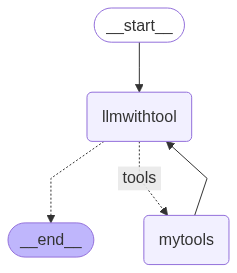

In [93]:
app2 = workflow2.compile()
app2

In [95]:
for output in app2.stream({"messages":["what is a weather in delhi can you tell me some good hotel for staying in north delhi"]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")

here is output from llmwithtool
_______
{'messages': [AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, so the user is asking about the weather in Delhi and also for some good hotels in North Delhi. Let me break this down. First, they want to know the current weather conditions in Delhi. I remember that the tool available is called "search" and it\'s used for weather searches. So I should use that tool with the query "weather in Delhi."\n\nNext, they\'re looking for hotels in North Delhi. I don\'t have a specific tool for hotels, but maybe the search tool can help with that as well. I can try using the search tool again with the query "good hotels in North Delhi" to find some options.\n\nI should make sure to call the search tool twice: once for the weather and once for the hotels. That way, I can provide both pieces of information the user is asking for. Let me structure the JSON for both calls accordingly.\n', 'tool_calls': [{'id': 'c7htjy78q', 'function': {'argume

## Configuring Memory in LangGraph

In [97]:
from langgraph.checkpoint.memory import MemorySaver

In [98]:
memory = MemorySaver()

In [99]:
workflow3 = StateGraph(MessagesState)

In [101]:
workflow3.add_node("llmwithtool", call_model)
workflow3.add_node("mytools", tool_node)


workflow3.add_edge(START, "llmwithtool")
workflow3.add_conditional_edges("llmwithtool",
                                router_function,
                                {"tools": "mytools",
                                END: END})
workflow3.add_edge("mytools", "llmwithtool")

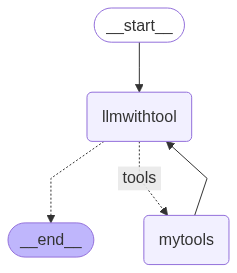

In [103]:
app3 = workflow3.compile(checkpointer=memory)
app3

In [104]:
config = {"configurable": {"thread_id": "1"}}

In [105]:
events = app3.stream(
    {"messages":["what is a weather in delhi can you tell me some good hotel for staying in north delhi"]}, 
    config=config, 
    stream_mode="values"
    )

In [106]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is a weather in delhi can you tell me some good hotel for staying in north delhi
================================== Ai Message ==================================
Tool Calls:
  search (2czaentn2)
 Call ID: 2czaentn2
  Args:
    query: Delhi weather
================================= Tool Message =================================
Name: search

the temp is 45 degree celsius
================================== Ai Message ==================================

Here are some good hotels in North Delhi for your stay:

1. **Hotel City Park** - Located in Pitampura, it offers comfortable rooms and good service.
2. **Hotel Sparrow** - Situated in Rohini, it provides a cozy stay with modern amenities.
3. **Hotel Regent** - In Lawrence Road, it’s known for its warm hospitality and clean rooms.
4. **Hotel Vogue** - Located in Shalimar Bagh, it offers a pleasant stay with a nice ambiance.
5. **Hotel Jivitesh** - In Civ

In [111]:
events = app3.stream(
    {"messages":["what is a weather in Indore can you tell me some good hotel for staying in Indore"]}, 
    config=config, 
    stream_mode="values"
    )

In [112]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is a weather in Indore can you tell me some good hotel for staying in Indore
================================== Ai Message ==================================
Tool Calls:
  search (0a2q02644)
 Call ID: 0a2q02644
  Args:
    query: Indore weather and hotels
================================= Tool Message =================================
Name: search

the temp is 25 degree celsius
================================== Ai Message ==================================

The current temperature in Indore is **25 degrees Celsius**. Here are some good hotels in Indore for your stay:

### Luxury Hotels:
1. **Taj Mahal Palace** - Known for its luxurious amenities and excellent service.
2. **JW Marriott Hotel Indore** - Offers a blend of comfort and elegance with modern facilities.

### Mid-Range Hotels:
1. **Lemon Tree Hotel Indore** - A popular choice for its convenient location and good service.
2. **Hotel Sayaji**

In [113]:
config

{'configurable': {'thread_id': '1'}}

In [114]:
memory.get(config)

{'v': 4,
 'ts': '2025-07-17T23:37:26.346722+00:00',
 'id': '1f06366f-ef06-679c-800b-e1b9c1838769',
 'channel_versions': {'__start__': '00000000000000000000000000000010.0.6990874921256403',
  'messages': '00000000000000000000000000000013.0.03220894608356217',
  'branch:to:llmwithtool': '00000000000000000000000000000013.0.03220894608356217',
  'branch:to:mytools': '00000000000000000000000000000012.0.6815593899410051'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000009.0.6598633483787762'},
  'llmwithtool': {'branch:to:llmwithtool': '00000000000000000000000000000012.0.6815593899410051'},
  'mytools': {'branch:to:mytools': '00000000000000000000000000000011.0.6271894556201686'}},
 'channel_values': {'messages': [HumanMessage(content='what is a weather in delhi can you tell me some good hotel for staying in north delhi', additional_kwargs={}, response_metadata={}, id='caa6ced8-0e2c-4229-9bae-62d57aa4f768'),
   AIMessage(content='', additional_

In [115]:
events=app3.stream(
    {"messages":["in which city the temp was 25 degree?"]},config=config,stream_mode="values"
    )

In [116]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

in which city the temp was 25 degree?
================================== Ai Message ==================================

The temperature of **25 degrees Celsius** was for **Indore**. Let me know if you need more details about Indore or any other assistance!


In [117]:
memory.get(config)


{'v': 4,
 'ts': '2025-07-17T23:39:04.958223+00:00',
 'id': '1f063673-9b75-640e-800e-aefb1c4fe8f2',
 'channel_versions': {'__start__': '00000000000000000000000000000015.0.6863044718002425',
  'messages': '00000000000000000000000000000016.0.524364838259091',
  'branch:to:llmwithtool': '00000000000000000000000000000016.0.524364838259091',
  'branch:to:mytools': '00000000000000000000000000000012.0.6815593899410051'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000014.0.924399137244661'},
  'llmwithtool': {'branch:to:llmwithtool': '00000000000000000000000000000015.0.6863044718002425'},
  'mytools': {'branch:to:mytools': '00000000000000000000000000000011.0.6271894556201686'}},
 'channel_values': {'messages': [HumanMessage(content='what is a weather in delhi can you tell me some good hotel for staying in north delhi', additional_kwargs={}, response_metadata={}, id='caa6ced8-0e2c-4229-9bae-62d57aa4f768'),
   AIMessage(content='', additional_kwarg